In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# lesson3 Image segmentation

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

## 数据集
1. [SegNet Tutorial](http://mi.eng.cam.ac.uk/projects/segnet/tutorial.html)
2. [alexgkendall/SegNet-Tutorial: Files for a tutorial to train SegNet for road scenes using the CamVid dataset](https://github.com/alexgkendall/SegNet-Tutorial)

In [3]:
# 下载数据集
# !git clone git@github.com:alexgkendall/SegNet-Tutorial.git

也可以使用 fastai 自己的数据

- **对单个图片的每个像素进行分类就是分割**

移动 CamVid 到datasets文件夹

In [4]:
# 设置数据集的路径
# root = Config.data_path()/'CamVid'
root = untar_data(URLs.CAMVID)
root

PosixPath('/home/lyc/.fastai/data/camvid')

In [5]:
# 查看路径下的文件和文件夹
root.ls()

[PosixPath('/home/lyc/.fastai/data/camvid/images'),
 PosixPath('/home/lyc/.fastai/data/camvid/labels'),
 PosixPath('/home/lyc/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/lyc/.fastai/data/camvid/valid.txt')]

## 数据处理

In [6]:
root_lbl = root/'labels'
root_img = root/'images'

In [7]:
fnames = get_image_files(root_img)
fnames[:3]

[PosixPath('/home/lyc/.fastai/data/camvid/images/0016E5_01530.png'),
 PosixPath('/home/lyc/.fastai/data/camvid/images/Seq05VD_f01620.png'),
 PosixPath('/home/lyc/.fastai/data/camvid/images/0016E5_08015.png')]

- 随机查看图片

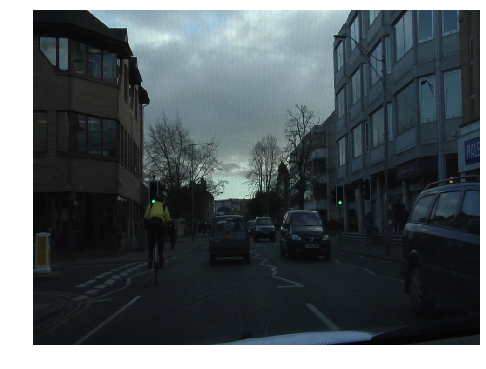

In [8]:
img_f = fnames[50]
img = open_image(img_f)
img.show(figsize=(8, 8))

- 获取对应标注的文件名

In [9]:
get_y_fn = lambda x: root_lbl/f'{x.stem}_P{x.suffix}'

- 查看对应的 mask

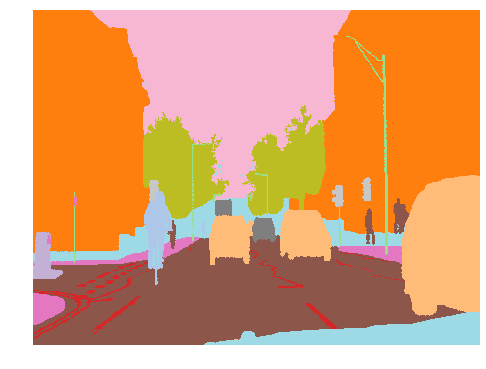

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(8,8), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size
mask.data

array([720, 960])

tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
         [ 4,  4,  4,  ...,  4,  4,  4],
         [ 4,  4,  4,  ...,  4,  4,  4],
         ...,
         [17, 17, 17,  ..., 30, 30, 30],
         [17, 17, 17,  ..., 30, 30, 30],
         [17, 17, 17,  ..., 30, 30, 30]]])

In [12]:
doc(open_mask)

open_mask [source] [test] open_mask ( fn : PathOrStr , div = False , convert_mode = 'L' , after_open : Callable = None ) → ImageSegment 
 
 × No tests found for open_mask . To contribute a test please refer to this guide and this discussion . Return ImageSegment object create from mask in file fn . If div , divides pixel values by 255. 
 Show in docs

- 查看对应的标签名

In [13]:
codes = np.loadtxt(root/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## 创建数据束 

In [14]:
size = src_size//2

- 根据显存大小设置 batchsize 这个还是非常有用的

In [15]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8116:
    bs=8
else:
    bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 6920MB of GPU RAM free


- 数据束创建流程
- 分割任务 SegmentationItemList

In [16]:
src = (SegmentationItemList.from_folder(root_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

- **分割任务中，对原始图像进行翻转的同时，也应当对对应的 mask 进行翻转，设置`tfm_y=True`**
- 因为需要对每个像素进行分类，所以自然而然会占用很大的空间，所以这里的batchsize应当小一些

In [17]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

- 查看 batch 数据也是检查 Databunch 是否创建成功

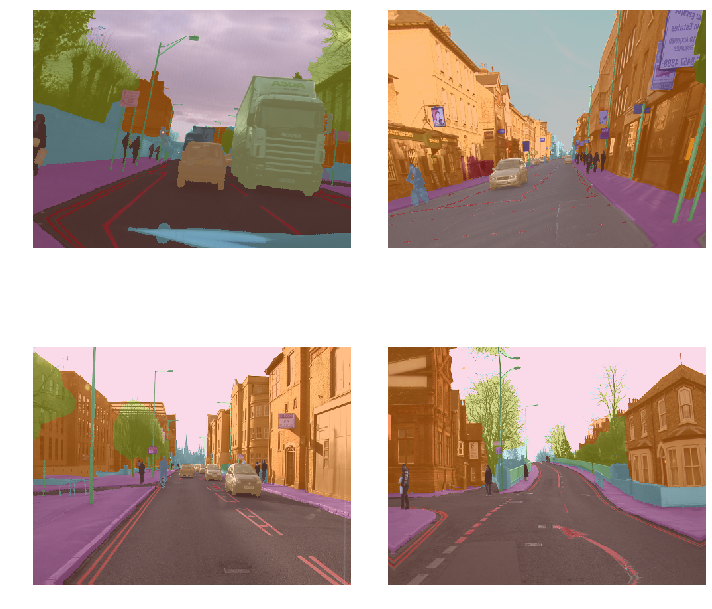

In [18]:
data.show_batch(2, figsize=(10,10))  # 训练集

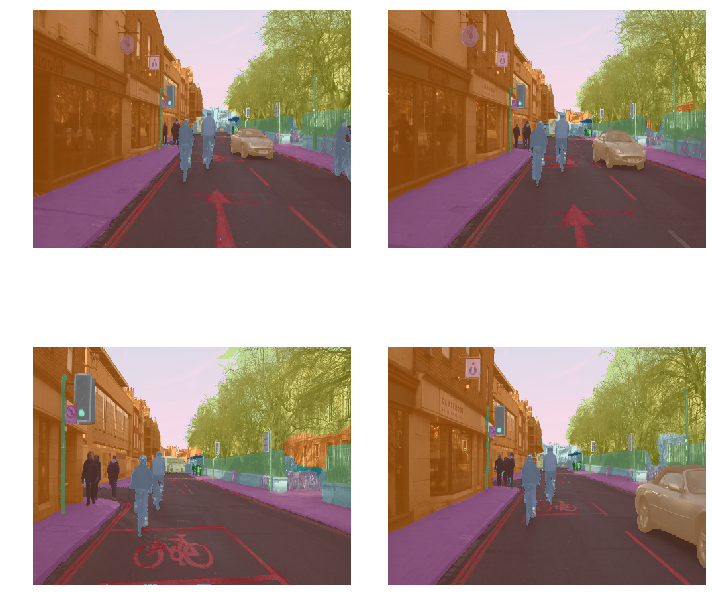

In [19]:
data.show_batch(2, figsize=(10,10), ds_type=DatasetType.Valid)  # 验证集

## 构建模型

In [21]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']  # void
void_code

30

- 定义 metrics

In [22]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [23]:
wd=1e-2  # 权重衰减
arch = models.resnet34

In [24]:
learn = unet_learner(data, arch, metrics=acc_camvid, wd=wd).to_fp16()

- 学习率

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


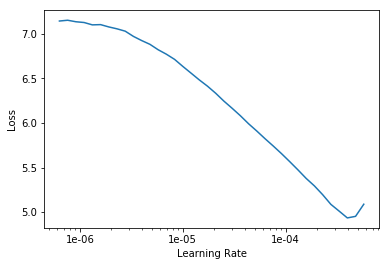

In [25]:
lr_find(learn)
learn.recorder.plot()

In [26]:
lr1 = 3e-4

- stage 1 训练

In [ ]:
learn.fit_one_cycle(10, slice(lr1), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time


In [ ]:
learn.save('stage-1-resnet34')

In [ ]:
learn.load('stage-1-resnet34')
learn.show_results(rows=3, figsize=(8,9))

- stage 2 训练

In [ ]:
learn.unfreeze()

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-2-resnet34')

## 使用更大的图片大小，并减小batchsize

In [ ]:
#learn.destroy() # uncomment once GPU is out

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
# 根据显存大小进行设置 1070TI 8116MiB
if free > 8116:
    bs=3
else:
    bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()

In [ ]:
learn.load('stage-2-resnet34')

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr2 = 3e-4

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big-resnet34')

In [ ]:
learn.load('stage-1-big-resnet34')

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big-resnet34')

In [ ]:
learn.load('stage-2-big-resnet34')

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## 其他

1. 我们应当逐步增加图片的大小，在这个过程中，我们不改变已经训练好的模型，而是更改数据
2.  "progressive resizing".64 以下的数字往往不会有太大的效果，但是它很好用
3. 分类正确的像素个数/所有的像素个数=准确度
4. 存在一些像素的标签是 void 在计算准确度的时候要排除这些像素
5. fit-one-cycle(lr) 传进去的是最大的 lr
6. 一开始我们使用128的图像，但是我们的任务是分割每个像素（256），所以并没有解决问题，那么第二步要做的就是增大图像到 256
7. learn.show_results() 可以查看模型的结果
8. learner.create_unet 使用unet作为结构
9. Mixed precision training 这也是一种有效的训练方式，它可以避免模型超出内存，即可以使用半精度浮点数在模型中执行大多数计算，而不是使用单精度浮点数 fp16 而不是 fp32,而且可以加速训练（保证驱动是最新的）